#### Setup

In [1]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import os
import re
import json

# connection to the database
import os
from sqlalchemy import create_engine

# set username/password here:
db = {'username': os.environ['DB_QIR_USERNAME'],
      'password': os.environ['DB_QIR_PASSWORD'],
      'host': 'www.quantleap.nl',  # localhost
      'catalog': 'qir'}


con = 'postgresql://{username}:{password}@{host}/{catalog}'.format(**db)
engine = create_engine(con, echo=True)
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Insolvents

In [2]:
sql = """select count(distinct case_number) 
         from company_insolvents"""

no_insolvents = pd.read_sql(sql, con).iloc[0][0]
print('the total number of insolvents cases in the database is {}'.format(no_insolvents))

the total number of insolvents cases in the database is 50319


In [3]:
sql = """select start_date_insolvency is not null as known, count(*)
         from company_insolvents
         group by start_date_insolvency is not null"""

df_known_start_date = pd.read_sql(sql, con)
print('fraction of known start date')
df_known_start_date

fraction of known start date


,known,count
0,False,3900
1,True,46419


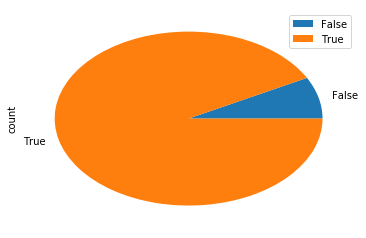

In [4]:
df_known_start_date.plot.pie(y='count', labels=df_known_start_date['known'])

## steekproef van niet OCR eindverslagen

### Wenselijke datavelden in het voortgangsverslag
Het voortgangsverslag hoort gestructureerd te zijn volgens de RECOFA richtlijnenm zie **model-verslag-faillissement-rechtspersoon.pdf**. In eerste instantie zijn we geinteresseerd in de data uit de **eindverslagen**.

Algemeen
- Personeel gemiddeld aantal: aantal
- Bestede uren totaal: aantal
- Saldo boedelrekening: bedrag


4 Debiteuren

4.2 Opbrengst: bedrag


7 Rechtmatigheid

7.2 Depot jaarrekeningen: wel/niet 

7.5 Onbehoorlijk bestuur: wel/niet


8 Crediteuren

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: bedrag

8.3 Preferente vorderingen van het UWV: bedrag

8.4 Andere preferente vorderingen: bedrag

8.5 Aantal concurrente crediteuren: bedrag

8.6 Bedrag concurrente crediteuren: bedrag



### Enige bevindingen / Issues
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?
- strikethrough in PDF komt niet terug in de tekstconversie
- PDFMiner wisselt soms woordvolgorde en mangled soms letters ook al staat dit duidelijk in het PDF

In [276]:
# store matched headers as json strings
df_reports['headings'] = df_reports['content'].apply(lambda x: json.dumps(match_headings(x)))
df_reports['headings'].head(n=20)

identification
01_obr_13_608_F_V_11     [["1.1", "Directie  en organisatie"], ["1.2", ...
01_obr_13_400_F_V_11     [["1.1", "Directie  en organisatie"], ["1.2", ...
01_obr_13_399_F_V_10     [["1.07", "2.175,-"], ["1.1", "Directie  en or...
01_obr_15_133_F_V_07     [["1.1", "Directie  en organisatie"], ["1.13",...
01_obr_14_973_F_V_08     [["1.1", "Directie  en organisatie"], ["76.95"...
10_rot_14_1054_F_V_10    [["1.1", "Directie en organisatie "], ["1.2", ...
10_rot_14_1055_F_V_10    [["1.1", "Directie en organisatie "], ["1.2", ...
10_rot_12_90_F_V_16      [["1.1", "Directie en Organisatie"], ["1.2", "...
11_rot_12_41_F_V_15      [["1.1", "Inventarisatie "], ["1.2", "Winst en...
13_ams_15_478_F_V_06     [["1.1", ".  Directie en organisatie "], ["1.2...
05_gel_16_674_F_V_05     [["1.1", "Directie en organisatie"], ["1.2", "...
05_gel_16_666_F_V_05     [["1.1", "Directie en organisatie"], ["1.2", "...
16_mne_16_568_F_V_01     [["1.1", "Directie en organisatie"], ["1.2", "...
05_gel_16_

In [277]:
df_reports['heading_numbers'] = df_reports['content'].apply(lambda x: json.dumps(get_heading_numbers(x)))
df_reports['heading_numbers'].head(n=20)

identification
01_obr_13_608_F_V_11     ["1.1", "1.2", "1.3", "1.4", "20.84", "46.29",...
01_obr_13_400_F_V_11     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "2....
01_obr_13_399_F_V_10     ["1.07", "1.1", "1.2", "1.3", "1.4", "1.5", "1...
01_obr_15_133_F_V_07     ["1.1", "1.13", "56.10", "1.2", "1.3", "1.4", ...
01_obr_14_973_F_V_08     ["1.1", "76.95", "68.09", "3.42", "1.2", "1.3"...
10_rot_14_1054_F_V_10    ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
10_rot_14_1055_F_V_10    ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
10_rot_12_90_F_V_16      ["1.1", "1.2", "1.4", "1.6", "2.1", "2.3", "3....
11_rot_12_41_F_V_15      ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
13_ams_15_478_F_V_06     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_674_F_V_05     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_666_F_V_05     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
16_mne_16_568_F_V_01     ["1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1....
05_gel_16_

In [278]:
# 
df_reports['strictly_increasing'] = df_reports['heading_numbers'].apply(
    lambda x: is_strictly_increasing_heading_numbers(json.loads(x)))
df_reports['strictly_increasing'].head(n=20)

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10    False
10_rot_14_1055_F_V_10    False
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05     False
05_gel_16_666_F_V_05     False
16_mne_16_568_F_V_01     False
05_gel_16_660_F_V_05     False
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09     False
01_obr_15_189_F_V_07      True
01_obr_15_188_F_V_08      True
13_ams_14_651_F_V_06      True
13_ams_14_497_F_V_07      True
Name: strictly_increasing, dtype: bool

In [279]:
# report percentage strictly increasing
df_reports['strictly_increasing'][df_reports['strictly_increasing'] == True].count() / df_reports['strictly_increasing'].count() * 100

26.100000000000001

In [280]:
df_reports['only_model_headings'] = df_reports['heading_numbers'].apply(
    lambda x: is_strictly_increasing_heading_numbers(json.loads(x)))
df_reports['strictly_increasing'].head(n=20)

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10    False
10_rot_14_1055_F_V_10    False
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05     False
05_gel_16_666_F_V_05     False
16_mne_16_568_F_V_01     False
05_gel_16_660_F_V_05     False
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09     False
01_obr_15_189_F_V_07      True
01_obr_15_188_F_V_08      True
13_ams_14_651_F_V_06      True
13_ams_14_497_F_V_07      True
Name: strictly_increasing, dtype: bool

In [281]:
df_reports['only_model_headings'] = df_reports['heading_numbers'].apply(lambda x: has_only_model_heading_numbers(json.loads(x)))
df_reports['only_model_headings'].head(n=20)

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10     True
10_rot_14_1055_F_V_10     True
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05      True
05_gel_16_666_F_V_05      True
16_mne_16_568_F_V_01      True
05_gel_16_660_F_V_05      True
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09      True
01_obr_15_189_F_V_07      True
01_obr_15_188_F_V_08      True
13_ams_14_651_F_V_06     False
13_ams_14_497_F_V_07     False
Name: only_model_headings, dtype: bool

In [282]:
# report percentage only model headings
df_reports['only_model_headings'][df_reports['only_model_headings'] == True].count() / df_reports['only_model_headings'].count() * 100

54.400000000000006

In [283]:
# inspect cases only model heading numbers but not strictly increasing
df_not_increasing = df_reports[df_reports.only_model_headings & (~df_reports.strictly_increasing)]
index = 20
print(df_not_increasing.index[index])
heading_numbers = list(zip(*json.loads(df_not_increasing.headings[index])))[0]
is_strictly_increasing_heading_numbers(heading_numbers)
for a, b in zip(heading_numbers, heading_numbers[1:]):
    print(float(a), float(b), float(a)<float(b))
    
# finding: in many reports 3.10 became 3.1 even though the PDF shows 3.10, PDFMiner issue ?


10_rot_14_762_F_V_09
1.1 1.2 True
1.2 1.3 True
1.3 1.5 True
1.5 1.7 True
1.7 2.1 True
2.1 2.3 True
2.3 5.1 True
5.1 5.2 True
5.2 5.4 True
5.4 5.6 True
5.6 5.8 True
5.8 7.1 True
7.1 7.2 True
7.2 7.4 True
7.4 8.1 True
8.1 8.3 True
8.3 8.5 True
8.5 7.6 False
7.6 10.1 True
10.1 10.3 True


In [284]:
# count heading number in model collection
df_reports['no_headings'] = df_reports['heading_numbers'].apply(
    lambda x: json.loads(x))
df_reports['only_model_headings'].head(n=20)

identification
01_obr_13_608_F_V_11     False
01_obr_13_400_F_V_11     False
01_obr_13_399_F_V_10     False
01_obr_15_133_F_V_07     False
01_obr_14_973_F_V_08     False
10_rot_14_1054_F_V_10     True
10_rot_14_1055_F_V_10     True
10_rot_12_90_F_V_16      False
11_rot_12_41_F_V_15      False
13_ams_15_478_F_V_06     False
05_gel_16_674_F_V_05      True
05_gel_16_666_F_V_05      True
16_mne_16_568_F_V_01      True
05_gel_16_660_F_V_05      True
01_obr_13_1204_F_V_04     True
01_obr_13_293_F_V_09      True
01_obr_15_189_F_V_07      True
01_obr_15_188_F_V_08      True
13_ams_14_651_F_V_06     False
13_ams_14_497_F_V_07     False
Name: only_model_headings, dtype: bool